# Example 5 - Data-driven robust optimisation 

In [13]:
using Distributions 
using Gurobi 
const GRB_ENV = Gurobi.Env()
myGurobi = ()->Gurobi.Optimizer(GRB_ENV)
using JuMP
using LinearAlgebra
using Plots

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-03


Let us first generate some data. We consider a bivariate normal distribution first without correlations.

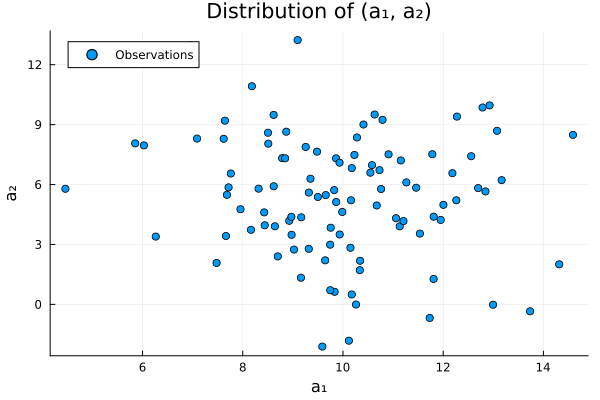

In [14]:
# Samples
a1 = rand(Normal(10, 2), 100)
a2 = rand(Normal(5, 3), 100);

scatter(
    a1,
    a2,
    label = "Observations",
    title = "Distribution of (a₁, a₂)",
    xaxis = ("a₁"),
    yaxis = ("a₂"),
    color = 1
)

We will first assume that our uncertainty sets are ellipsoids. We can use our information about the data process to define our ellipsoidal uncertainty sets by centrering them on the average values and using the respective standard deviations as the ellipsoid radi.

Thus our ellipsoid can be defined as:
\begin{equation*}
    e = \mu + \Gamma \begin{bmatrix} \sigma_1 & 0 \\ 0 & \sigma_2 \end{bmatrix} u. 
\end{equation*}

To plot the ellipsoid boundary points we use a coodinate transformation trick $t \mapsto (\cos(t), \sin(t))$, for $t \in [0, 2\pi]$.

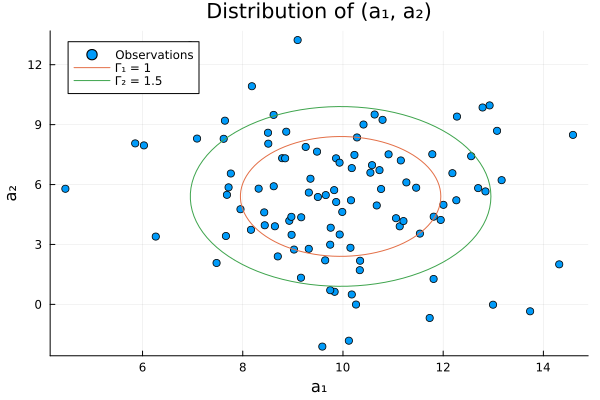

In [15]:
Γ₁ = 1
Γ₂ = 1.5

t = LinRange(0, 2 * π, 100)
e₁ = [2 0; 0 3] * (Γ₁ .* [cos.(t)'; sin.(t)'])
e₂ = [2 0; 0 3] * (Γ₂ .* [cos.(t)'; sin.(t)'])

plot!(e₁[1, :] .+ mean(a1), e₁[2, :] .+ mean(a2), label = "Γ₁ = 1")
plot!(e₂[1, :] .+ mean(a1), e₂[2, :] .+ mean(a2), label = "Γ₂ = 1.5")

The above sort of works, but clearly overlooks considerable information that we can obtain from the data itself. For example, let's repeat the placement of the ellipsoidal uncertainty set considering correlated data.

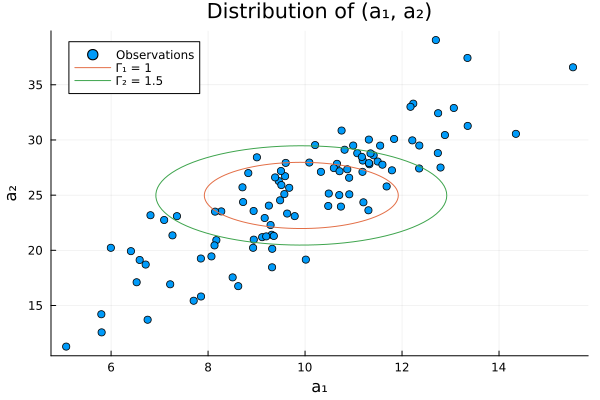

In [16]:
# Samples
a1 = rand(Normal(10, 2), 100)
a2 = rand(Normal(5, 3), 100) + a1.*2; # Creates correlation between a₁ and a₂

scatter(
    a1,
    a2,
    label = "Observations",
    title = "Distribution of (a₁, a₂)",
    xaxis = ("a₁"),
    yaxis = ("a₂"),
    color = 1
)

Γ₁ = 1
Γ₂ = 1.5

t = LinRange(0, 2 * π, 100)
e₁ = [2 0; 0 3] * (Γ₁ .* [cos.(t)'; sin.(t)'])
e₂ = [2 0; 0 3] * (Γ₂ .* [cos.(t)'; sin.(t)'])

plot!(e₁[1, :] .+ mean(a1), e₁[2, :] .+ mean(a2), label = "Γ₁ = 1")
plot!(e₂[1, :] .+ mean(a1), e₂[2, :] .+ mean(a2), label = "Γ₂ = 1.5")


Notice that this does not seem as efficient once the data presents correlation. 

Turns out that ellipsoids are great for describing multi-variate data and can be used to describe data hulls given an specific confidence.

Let's first think of the case with or correltion. Notice that our ellipsoind can equivalently represented as such:
\begin{equation*}
    \sum_{j=1}^N \left(\frac{x_j}{\sigma_{x_j}}\right)^2 = \Gamma
\end{equation*}

It so turns out that $\Gamma$ became the sum of the squared independent normal distributions, and thus behaves as a Chi-squared (with $N$ degrees of freedom).

This means that we can use probability values to define $\Gamma$, i.e.,
\begin{equation*}
    P(s \le \Gamma) = 1 - \alpha
\end{equation*}

where, $s$ comes from a chi-probability "table".

The generalisation to include the covariance requires that we consider its engenvectors (which orient the ellipsoid) and its eigenvalues (whose squared root give its radii).

Let $V,\lambda$ be the eigenvectors and eigenvalues of $s\Sigma$, which is the covariance matrix scaled by $s$. Then, our ellipsoids characteristic matrix becomes $P = \sqrt{\lambda}V$.

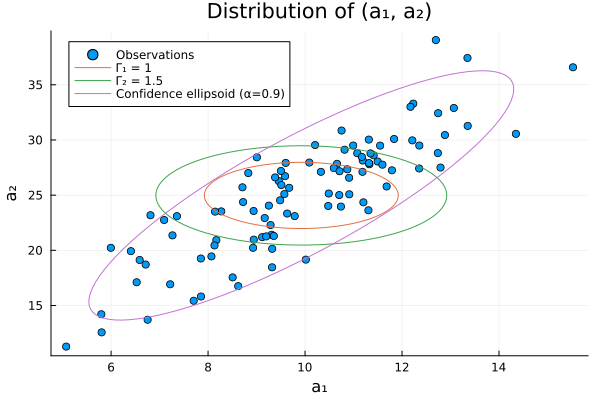

In [17]:
data = [a1 a2]

sigma = cov(data) # covariance matrix
p = .9
s = cquantile(Chisq(2), 1 - p) # Chi-squared with 2 degrees of freedom
λ, V = eigen(sigma .* s)

t = LinRange(0, 2 * π, 100)
a = V' * (sqrt.(λ) .* [cos.(t)'; sin.(t)'])

plot!(a[1, :] .+ mean(a1), a[2, :] .+ mean(a2),
    label = "Confidence ellipsoid (α=$(p))",
)

## Robust knapsack problem

Let us consider a version of the knapsack problem under uncertainty. In that, we have to make a selection of items with uncertain weights aiming to maximise the selection value, whilst observing a weight budget.

Let:
- $J$ - set of items
- $c_{j}$ - value of item $j \in J$
- $a_{j}$ - item $j \in J$ weight
- $b$ - weight budget

Our determinist knapsack problem can be stated as:
\begin{align*}
    \min~ & c^\top x \\		
    \text{s.t.:~} & \sum_{j \in [n]} a_j x_j \le b \\
    & x_j \in \{0,1\}, \ \forall j \in [n].
\end{align*}

### Robust counterpart

We will assume that all weights $a_j$, for $j \in J$, are uncertain. Using an ellipsoidal uncertainty set, we obtain the following robust counterpart:

\begin{align*}
    \min~ & c^\top x \\		
    \text{s.t.:~} & \sum_{j \in [n]} a_j x_j + \Gamma\sqrt{\sum_{j \in [n]} (\hat{a} x_j)^2} \le b \\
    & x_j \in \{0,1\}, \ \forall j \in [n].
\end{align*}

First, let us define how we create our instance and the random data associated.


In [18]:
mutable struct Instance
   N
   item_value
   weight_avg
   weight_stdev
   capacity
end

# We consider 50 items
N = 50
#Input data
item_value = rand(10:100, N)
weight_avg = rand(10:100, N)
weight_stdev = weight_avg .* 0.55 # weights standard deviation

#Randomly generating initial data using multivariate normal distribution
weight_data = zeros(100, N)
for j= 1:N
   weight_data[:,j] = rand(Normal(weight_avg[j], weight_stdev[j]), 100)
end

#Input data: weight limit (capacity)
capacity = ceil(mean(weight_avg) * N * 0.5) # roughly fits 50% the items

ins = Instance(N, item_value, weight_avg, weight_stdev,capacity)

# # Protection elipsoid: uses the stdev as nominal protection level
P = diagm(weight_stdev);

Let us define solving the model and estimate its feasiblity as functions. The function `feasibility_estimate(instance, solution, repetitions)` works as follows:
1. For a given number of `repetitions`, sample weights from a multivariate normal distribution
2. For each sample, keep track of when the budget $b$ is violated by the given `solution`
3. Estimate the feasibility probability by the ratio of non-violated samples and `repetitions`


In [19]:
#=
solve_robust_model_ellipsoid(instance, P, Γ): 
- inputs
    1. instance: knapsack problem instance (::Instance)
    2. P: ellipsoid characteristic matrix
    3. Γ: confidence level (robustness budget)
- output
    1. x: optimal selection
=#
function solve_robust_model_ellipsoid(instance, P, Γ=1)
    N, item_value, weight_avg, weight_stdev, capacity = instance.N, instance.item_value, instance.weight_avg, instance.weight_stdev, instance.capacity    

    m = Model(myGurobi) #creates the model, select the solver
    set_silent(m)
    @variable(m, x[1:N], Bin) 
    
    # Two below combined yield 
    @expression(m, t, (capacity - sum(weight_avg[j] * x[j] for j = 1:N)))
    @constraint(m, [t; Γ .* (P * x)] in SecondOrderCone()) # means t ≥ Γ||Px||
    
    #+ Γ||Px|| <= b -ax 

    @objective(m, Max, sum(item_value[j] * x[j] for j = 1:N))
    optimize!(m)

    return value.(x)
end

#=
feasibility_estimate(instance, solution, repetitions):
- input:
    1. instance: knapsack problem instance (::Instance)
    2. solution: selection to be evaluated
    3. repetitions: number of repetitions (simulations)
=#
function feasibility_estimate(instance, solution, repetitions)
    N, weight_avg, weight_stdev, capacity = instance.N, instance.weight_avg, instance.weight_stdev, instance.capacity    
    feasible_count = 0
    actual_weight = zeros(N)
    for n= 1:repetitions
        for j= 1:N
           # generate random weights according to distribution
           actual_weight[j] = rand(Normal(weight_avg[j], weight_stdev[j]))
        end
        #if total weight more than capacity => problem infeasible.
        if dot(actual_weight, solution) <= capacity
            feasible_count += 1
        end
    end
    return feasible_count / repetitions
end;

We can now estimate the the *price of robustness* of our solution, meaning that we calculate:
1. The cost decrease observed as we increase $\Gamma$ 
2. The experimental feasibility probability observed

In [20]:
#=
 estimate_price_robustness_ellipsoid(instance, P; max_Γ=2, repetitions=5000):
 - inputs
    1. instance: knapsack problem instance (::Instance)
    2. P: ellipsoid characteristic matrix
    3. max_Γ: upper bracket of the range [0, max_Γ], increments of 0.1
    4. repetitions: number of repetitions (simulations)
=#
function estimate_price_robustness_ellipsoid(instance, P; max_Γ=2, repetitions=5000)
    Γ_range = 0:0.5:max_Γ
    # storing the results of each run
    feas = []
    total_value = []
    Γ_used = []
    # for each Gamma, solve te model and store the results
    for Γ in Γ_range
        x = solve_robust_model_ellipsoid(instance, P, Γ)
        push!(Γ_used, Γ)
        push!(feas, feasibility_estimate(instance, x, repetitions))
        push!(total_value, dot(instance.item_value, x))
    end

    # plotting the results from simulation
    p1 = plot(Γ_used, feas, xlabel = "Γ", ylabel = "feas. prob.",label="exp.")
    p2 = plot(Γ_used, total_value, xlabel = "Γ", ylabel = "total value", legend=false, color=:orange)
    plot(p1,p2, layout = (2,1))
end    

estimate_price_robustness_ellipsoid (generic function with 1 method)

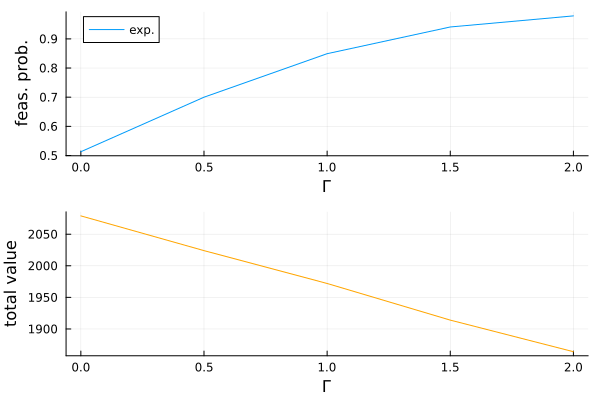

In [21]:
estimate_price_robustness_ellipsoid(ins, P)

The above was done disregarding the data itself, apart from the parametrisation of the Normal. Let us know consider the data-driven version that adjust to the data itself. 

Notice that this may not be always ideal. Using the data may "overinflate" the ellipsoid, for example, due to outliers.


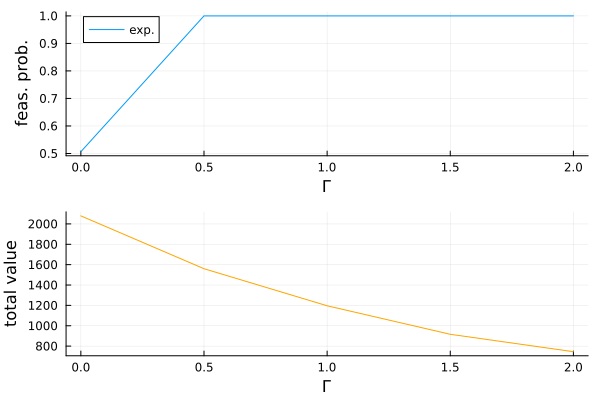

In [22]:
sigma = cov(weight_data)
p = .9
s = cquantile(Chisq(N), 1 - p) # Chi-squared with N degrees of freedom
λ, V = eigen(sigma .* s)

t = LinRange(0, 2 * π, 100)
ddP = V .* (sqrt.(λ))
estimate_price_robustness_ellipsoid(ins, ddP)

## Polyhedral uncertainty set

Let us consider now the polyheadrl uncertainty set from Bertsimas and Sim, (2004).

Recall that our robust counterpart is defined as:

\begin{align*}
    \min~ & c^\top x \\		
    \text{s.t.:~} & \sum_{j \in [n]} a_j x_j + \Gamma \pi + \sum_{j \in [n]} p_j \le b \\
    & \pi + p_j \ge \hat{a}_j x_j, \ \forall j \in [n] \\
    & x_j \in \{0,1\} \le 1, p_j \ge 0, \ \forall j \in [n] \\
    & \pi \ge 0.
\end{align*}


In [23]:
#=
solve_robust_model_ellipsoid(instance, Γ): 
- inputs
    1. instance: knapsack problem instance (::Instance)
    2. Γ: confidence level (robustness budget)
- output
    1. x: optimal selection
=#
function solve_robust_model_polyhedral(instance, Γ)
    N, item_value, weight_avg, weight_stdev, capacity = instance.N, instance.item_value, instance.weight_avg, instance.weight_stdev, instance.capacity    
    m = Model(myGurobi) #creates the model, select the solver
    set_silent(m)
    @variable(m, x[1:N], Bin) 
    @variable(m, p[1:N] ≥ 0) 
    @variable(m, π ≥ 0) 
    @constraint(m, sum(weight_avg[j] * x[j] for j = 1:N) + Γ * π + sum(p[j] for j in 1:N) <= capacity) 
    @constraint(m, [j in 1:N], π + p[j] ≥ weight_stdev[j] * x[j])
    @objective(m, Max, sum(item_value[j] * x[j] for j = 1:N)) # declare the objective function
    optimize!(m)

    return value.(x)
end

#=
 estimate_price_robustness_ellipsoid(instance, P; max_Γ=2, repetitions=5000):
 - inputs
    1. instance: knapsack problem instance (::Instance)
    2. max_Γ: upper bracket of the range [0, max_Γ], increments of 1
    3. repetitions: number of repetitions (simulations)
=#
function estimate_price_robustness_polyhedral(instance; max_Γ=10, repetitions=5000)
    Γ_range = 0:1:max_Γ
    # storing the results of each run
    feas = []
    total_value = []
    Γ_used = []
    # for each Gamma, solve te model and store the results
    for Γ in Γ_range
        x = solve_robust_model_polyhedral(instance, Γ)
        push!(Γ_used, Γ)
        push!(feas, feasibility_estimate(instance, x, repetitions))
        push!(total_value, dot(instance.item_value, x))
    end

    feas_theoretical = [1 - exp((-Γ^2)/(2*(instance.N))) for  Γ in Γ_range]

    # plotting the results from simulation
    p1 = plot(Γ_used, feas, xlabel = "Γ", ylabel = "feas. prob.", label="exp.")
    p1 = plot!(Γ_used, feas_theoretical, xlabel = "Γ", ylabel = "feas. prob.", label="theo.")
    p2 = plot(Γ_used, total_value, xlabel = "Γ", ylabel = "total value", legend=false, color=:orange)
    plot(p1,p2, layout = (2,1))
end    

estimate_price_robustness_polyhedral (generic function with 1 method)

We repeat the same experiment with the polyhedral uncertainty set. We also show a comparison with the theoretical feasibility bound.

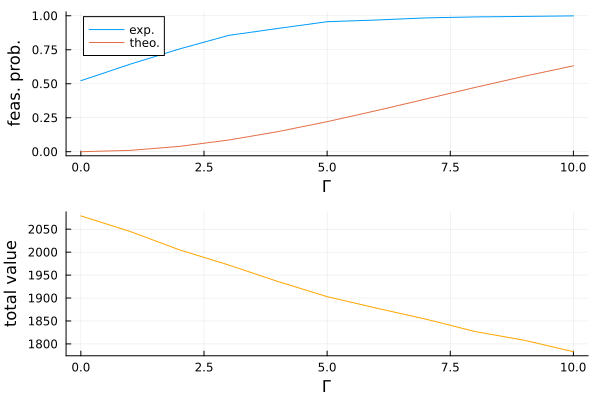

In [24]:
estimate_price_robustness_polyhedral(ins)